In [ ]:
import anndata as ad
import numpy as np
import spateo as st

# Load data
adata = ad.read_h5ad("./E14-16h_a_SCT_wholebody.h5ad")

# reconstruct whole body points cloud
pc = st.tl.construct_pc(adata=adata, spatial_key="spatial", groupby="annotation", key_added="groups")

# Add gene expression to pc
gene_name = "BBS1"

gene_exp = adata[:, gene_name].X.flatten().astype(np.float64)
gene_exp_adj = gene_exp.copy()
gene_exp_adj[gene_exp_adj <= 0.2] = 0

gene_exp_alpha = gene_exp.copy()
gene_exp_alpha = gene_exp_alpha / gene_exp_alpha.max()
gene_exp_alpha[gene_exp_alpha <= 0.1] = 0.1
st.tl.add_mesh_labels(mesh=pc, labels=gene_exp_adj, key_added=gene_name, where="point_data", colormap="Purples", alphamap=gene_exp_alpha)

# reconstruct whole body surface
surface, pc = st.tl.construct_surface(pc=pc, key_added="groups", cs_method="alpha_shape", cs_args={"alpha": 3})

# reconstruct whole body volume
volume = st.tl.construct_volume(mesh=surface, key_added="groups", volume_smoothness=200, alpha=1.0)

# Add gene expression to volume
initial_exp = np.array([0] * volume.n_points).astype(np.float64)
st.tl.add_mesh_labels(mesh=volume, labels=initial_exp, key_added=gene_name, where="point_data", colormap="gainsboro", alphamap=0.1)
new_volume = st.tl.merge_mesh([volume, pc])
st.tl.save_mesh(new_volume, filename="./volume_gene.vtk")
new_volume.plot()


/lab/solexa_weissman/xqiu/python37_nice/lib/python3.7/site-packages/geopandas-0.10.2-py3.7.egg/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
2022-03-30 11:57:58.397015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lab/solexa_weissman/xqiu/python37_nice/lib/python3.7/site-packages/cv2/../../lib64:
2022-03-30 11:57:58.397057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refa

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
import numpy as np
import pandas as pd
import anndata as ad

import spateo as st


def interpolation_SparseVFC(
    X, V, grid_num=50, lambda_=0.02, lstsq_method="scipy", **kwargs
) -> np.ndarray:
    from dynamo.vectorfield import vector_field_function
    from dynamo.vectorfield.scVectorField import SparseVFC

    # Generate grid
    min_vec, max_vec = (
        X.min(0),
        X.max(0),
    )
    min_vec = min_vec - 0.01 * np.abs(max_vec - min_vec)
    max_vec = max_vec + 0.01 * np.abs(max_vec - min_vec)
    Grid_list = np.meshgrid(
        *[np.linspace(i, j, grid_num) for i, j in zip(min_vec, max_vec)]
    )
    Grid = np.array([i.flatten() for i in Grid_list]).T

    # Get the new adata after interpolation (Not only for 3D coordinate data, but also for 2D coordinate data).
    res = SparseVFC(X, V, Grid, lambda_=lambda_, lstsq_method=lstsq_method, **kwargs)
    three_d_func = lambda x: vector_field_function(x, res)

    return three_d_func(X)


# Load data
volume = sp.tl.read_mesh("./volume_gene.vtk")
print(volume.point_data)
X = volume.points
V = volume.point_data["BBS1"]
V = V.reshape(V.shape[0], 1)
# new_gene_exp = interpolation_SparseVFC(X=X, V=V)
# data = pd.DataFrame(new_gene_exp)
# data.to_csv("interpolation.csv", index=False, header=False)

adata = ad.read_h5ad(r"./E14-16h_a_SCT_wholebody.h5ad")

# reconstruct whole body points cloud
pc = st.tl.construct_pc(adata=adata, spatial_key="spatial", groupby="annotation", key_added="groups")

# Add gene expression to pc
gene_name = "BBS1"

from spateo.tools import DataSampler, DeepInterpolation
from spateo.tools import interpolation_nn

# take existing data point to train the model
data_dict = {"X": adata.obsm['spatial'], "Y": adata[:, gene_name].X}

# Data sampler 
velocity_data_sampler = DataSampler(data=data_dict, normalize_data=False)

# set uip the deep learning model 
NN_model = DeepInterpolation(model=interpolation_nn,
                             data_sampler=velocity_data_sampler,
                             enforce_positivity=False,
                             )

# train the deep learning model
NN_model.train(max_iter=1000,
               data_batch_size=5000,
               autoencoder_batch_size=50,
               data_lr=1e-4,
               autoencoder_lr=1e-4
               )

# predict on all voxel:
V_NN = NN_model.predict(input_x=X)

# save data 
pd.DataFrame(V_NN).to_csv("deep_interpolation.csv", index=False, header=False)

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : BBS1_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    BBS1_rgba               float64  (364660, 4)          SCALARS
    BBS1                    float64  (364660,)
Iter [     100] Time [4.0974] regression loss [0.8875] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     200] Time [7.9015] regression loss [0.8632] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     300] Time [11.8421] regression loss [0.8660] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     400] Time [15.5514] regression loss [0.8394] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     500] Time [19.5948] regression loss [0.9850] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     600] Time [23.5218] regression loss [0.9223] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     700] Time [27.4803] regressio

In [4]:
import numpy as np
import pandas as pd
import spateo as st

# interpolation_gene_exp = pd.read_csv("./interpolation.csv", header=None, dtype=np.float64)
interpolation_gene_exp = pd.read_csv("./deep_interpolation.csv", header=None, dtype=np.float64)

interpolation_gene_exp = interpolation_gene_exp.values.round(4).astype(np.float32)
interpolation_gene_exp = np.asarray(interpolation_gene_exp).flatten()

volume = st.tl.read_mesh("./volume_gene.vtk")
st.tl.add_mesh_labels(mesh=volume, labels=interpolation_gene_exp, key_added="continuous_CG7406", where="point_data",
                      colormap="Purples", alphamap=1.0)


/lab/solexa_weissman/xqiu/python37_nice/lib/python3.7/site-packages/geopandas-0.10.2-py3.7.egg/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
2022-03-30 12:50:20.335167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lab/solexa_weissman/xqiu/python37_nice/lib/python3.7/site-packages/cv2/../../lib64:
2022-03-30 12:50:20.335209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


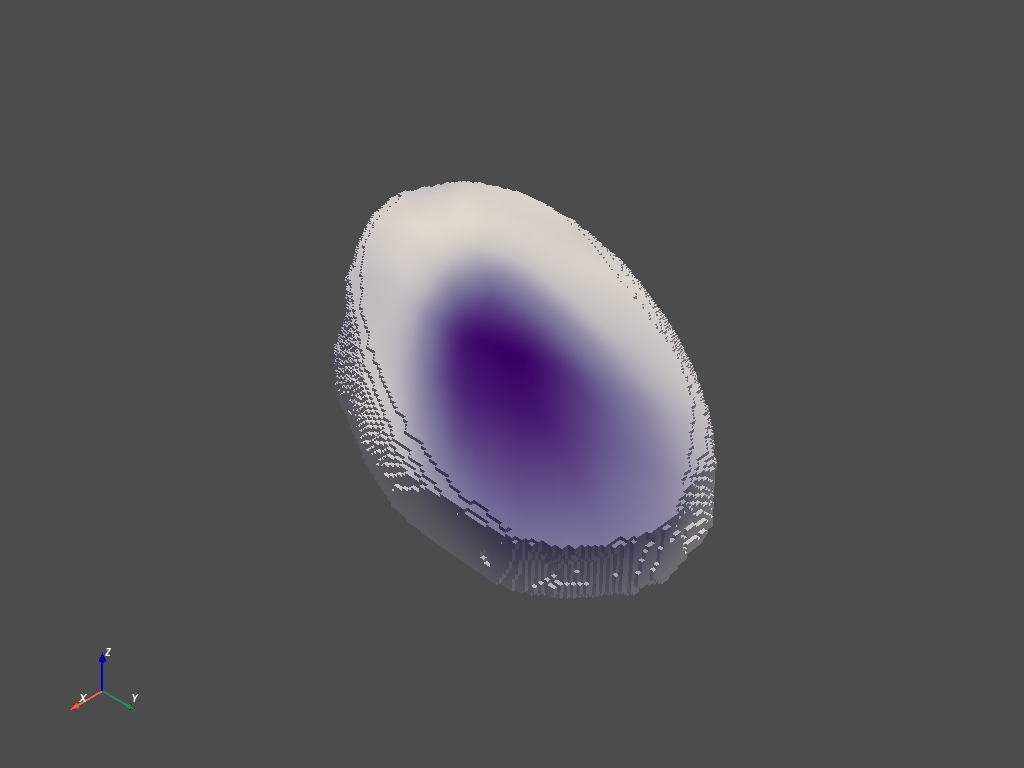

In [7]:
pv.start_xvfb()

volume.plot(return_cpos=False, jupyter_backend='pythreejs', notebook=True) # , notebook=True
#     * ``'none'`` : Do not display in the notebook.
#     * ``'static'`` : Display a static figure.
#     * ``'ipygany'`` : Show a ``ipygany`` widget
#     * ``'panel'`` : Show a ``panel`` widget.

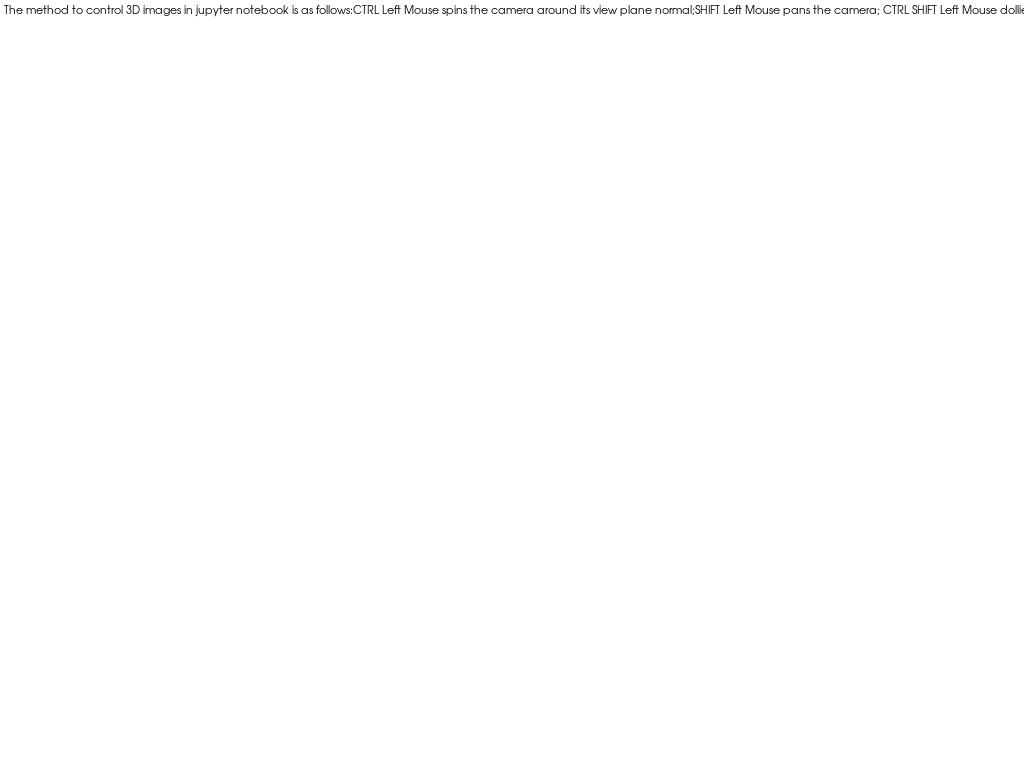

In [10]:
import pyvista as pv
import spateo as sp
p = sp.pl.create_plotter(jupyter=True, off_screen=False, window_size=(1024, 768), initial_cpo="iso")
p.add_mesh(volume)
p.show(return_cpos=False, jupyter_backend="pythreejs")

In [2]:
import pyvista as pv
from pyvista import examples 
pv.start_xvfb()

mesh = examples.download_lucy()
mesh.plot(color='lightgrey', pbr=True, metallic=0.2, jupyter_backend='ipygany') # ipygany

Scene(background_color='#4c4c4c', camera={'position': [1763.850044114321, 951.345535142153, 1265.6030043193991…

In [ ]:
import pyvista as pv
from pyvista import examples

# download an example and display it using physically based rendering.
mesh = examples.download_lucy()
mesh.plot(color='lightgrey', pbr=True, metallic=0.2,
          jupyter_backend='ipyvtklink ')